<a href="https://colab.research.google.com/github/adrian-deguzman/PyTorch-Deep-Learning/blob/Computer-Vision/Cats_vs_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSCI 118.03 Image Classification Lab

This dataset is based off of Google's Dogs vs Cats image dataset.

## Objectives

* Be able to train a convolutional neural network for image classification
* Be able to customize the architecture of a CNN based neural network for image classification

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-03-13 07:33:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.4MB/s    in 3.9s    

2025-03-13 07:33:59 (16.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.582.jpg', 'cat.452.jpg', 'cat.249.jpg', 'cat.217.jpg', 'cat.842.jpg', 'cat.394.jpg', 'cat.100.jpg', 'cat.849.jpg', 'cat.54.jpg', 'cat.848.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

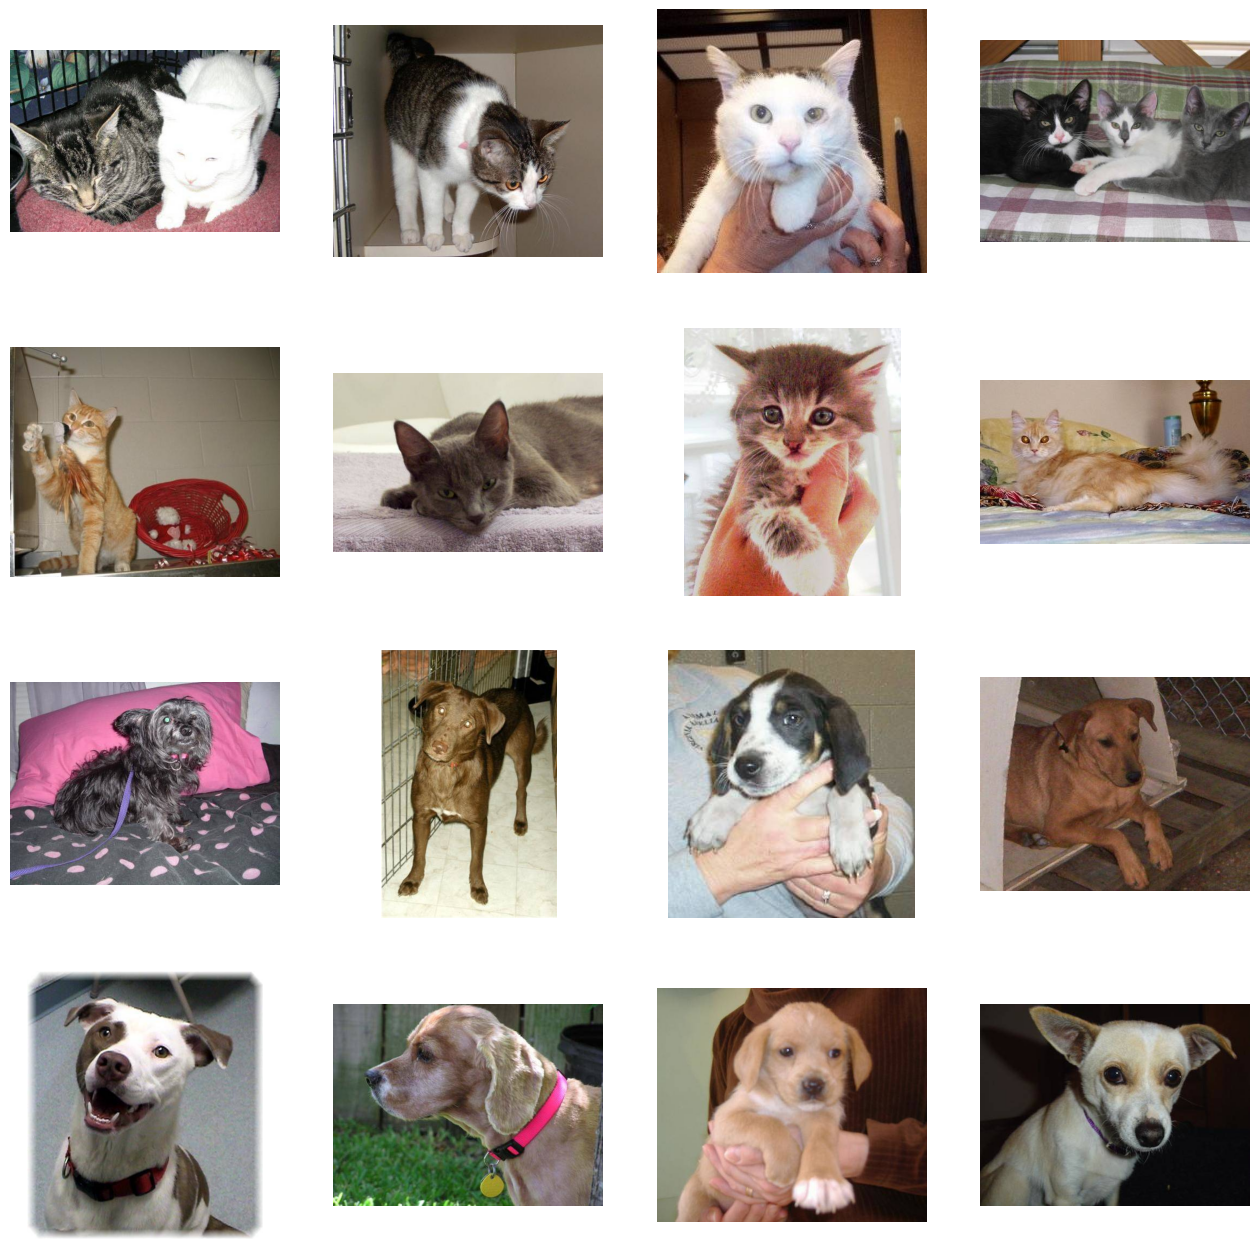

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building CNN based Neural Network

These are the imports for the libraries necessary for our models.

In [ ]:
# Install required libraries
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.image as mpimg

# seed value
seed = 12

# Set fixed seed
torch.manual_seed(seed)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transforms for data preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

validation_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### Baseline CNN

In [ ]:
# Accuracy: 71.60%
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Create a dummy input to find out the size after conv layers
        self._initialize_fc()

    def _initialize_fc(self):
        # Forward pass a dummy input to calculate the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)  # Batch size 1, 3 channels, 150x150
            dummy_output = self.pool(torch.relu(self.conv2(self.pool(torch.relu(self.conv1(dummy_input))))))
            flattened_size = dummy_output.view(-1).shape[0]

        # Define fully connected layers based on this calculated size
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

    def name(self):
        return "SimpleCNN"

### CNN 5 Conv Layers

In [ ]:
# Validation Accuracy: 80.00 %
class CNNv2(nn.Module):
    def __init__(self):
        super(CNNv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers
        self._initialize_fc()

    def _initialize_fc(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            dummy_output = self.pool(torch.relu(self.bn2(self.conv2(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn3(self.conv3(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn4(self.conv4(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn5(self.conv5(dummy_output))))
            flattened_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def name(self):
        return "CNNv2"

### CNN 7 Conv Layers

In [ ]:
# Validation Accuracy: 82.90 %
class CNNv4(nn.Module):
    def __init__(self):
        super(CNNv4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.conv6 = nn.Conv2d(1024, 2048, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)
        self.conv7 = nn.Conv2d(2048, 4096, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(4096)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers
        self._initialize_fc()

    def _initialize_fc(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            dummy_output = self.pool(torch.relu(self.bn2(self.conv2(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn3(self.conv3(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn4(self.conv4(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn5(self.conv5(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn6(self.conv6(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn7(self.conv7(dummy_output))))
            flattened_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.pool(torch.relu(self.bn6(self.conv6(x))))
        x = self.pool(torch.relu(self.bn7(self.conv7(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def name(self):
        return "CNNv4"

### Setting hyperparameters

In [ ]:
# Set model
model = CNNv2().to(device)

# Define hyperparameters
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32
epochs = 100

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, worker_init_fn=np.random.seed(seed))
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False, worker_init_fn=np.random.seed(seed))

# Get a batch from train_loader and get shape
image, _ = next(iter(train_loader))
print(f"Image shape: {image.shape}")

model

Image shape: torch.Size([32, 3, 150, 150])


CNNv2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_feat

### Training and Evaluating the model

Model: CNNv2



Epoch 1, Loss: 1.103287


Epoch 2, Loss: 0.702199


Epoch 3, Loss: 0.670021


Epoch 4, Loss: 0.655424


Epoch 5, Loss: 0.618633


Epoch 6, Loss: 0.594168


Epoch 7, Loss: 0.564230


Epoch 8, Loss: 0.548074


Epoch 9, Loss: 0.537315


Epoch 10, Loss: 0.510284


Epoch 11, Loss: 0.492251


Epoch 12, Loss: 0.468206


Epoch 13, Loss: 0.444249


Epoch 14, Loss: 0.409795


Epoch 15, Loss: 0.417034


Epoch 16, Loss: 0.376697


Epoch 17, Loss: 0.366046


Epoch 18, Loss: 0.326539


Epoch 19, Loss: 0.322982


Epoch 20, Loss: 0.284330


Epoch 21, Loss: 0.296487


Epoch 22, Loss: 0.301204


Epoch 23, Loss: 0.257194


Epoch 24, Loss: 0.254446


Epoch 25, Loss: 0.220026


Epoch 26, Loss: 0.188064


Epoch 27, Loss: 0.209141


Epoch 28, Loss: 0.204147


Epoch 29, Loss: 0.169523


Epoch 30, Loss: 0.165841


Epoch 31, Loss: 0.141265


Epoch 32, Loss: 0.133669


Epoch 33, Loss: 0.103926


Epoch 34, Loss: 0.142107


Epoch 35, Loss: 0.097091


Epoch 36, Loss: 0.119459


Epoch 37, Loss: 0.107668


Epoch 38, Loss: 0.078663


Epoch 39, Loss: 0.076448


Epoch 40, Loss: 0.076541


Epoch 41, Loss: 0.066335


Epoch 42, Loss: 0.057209


Epoch 43, Loss: 0.078631


Epoch 44, Loss: 0.060550


Epoch 45, Loss: 0.055375


Epoch 46, Loss: 0.092285


Epoch 47, Loss: 0.037763


Epoch 48, Loss: 0.065564


Epoch 49, Loss: 0.026609


Epoch 50, Loss: 0.044736


Epoch 51, Loss: 0.105632


Epoch 52, Loss: 0.040207


Epoch 53, Loss: 0.023254


Epoch 54, Loss: 0.028174


Epoch 55, Loss: 0.041003


Epoch 56, Loss: 0.054196


Epoch 57, Loss: 0.032392


Epoch 58, Loss: 0.039559


Epoch 59, Loss: 0.033765


Epoch 60, Loss: 0.028319


Epoch 61, Loss: 0.040505


Epoch 62, Loss: 0.043092


Epoch 63, Loss: 0.059339


Epoch 64, Loss: 0.015295


Epoch 65, Loss: 0.014930


Epoch 66, Loss: 0.023102


Epoch 67, Loss: 0.024805


Epoch 68, Loss: 0.009450


Epoch 69, Loss: 0.002344


Epoch 70, Loss: 0.001193


Epoch 71, Loss: 0.005473


Epoch 72, Loss: 0.043807


Epoch 73, Loss: 0.053702


Epoch 74, Loss: 0.023965


Epoch 75, Loss: 0.038203


Epoch 76, Loss: 0.011453


Epoch 77, Loss: 0.003612


Epoch 78, Loss: 0.009072


Epoch 79, Loss: 0.040300


Epoch 80, Loss: 0.044180


Epoch 81, Loss: 0.018738


Epoch 82, Loss: 0.008991


Epoch 83, Loss: 0.005405


Epoch 84, Loss: 0.042233


Epoch 85, Loss: 0.037388


Epoch 86, Loss: 0.005070


Epoch 87, Loss: 0.005039


Epoch 88, Loss: 0.065197


Epoch 89, Loss: 0.064012


Epoch 90, Loss: 0.042074


Epoch 91, Loss: 0.011155


Epoch 92, Loss: 0.005574


Epoch 93, Loss: 0.018252


Epoch 94, Loss: 0.038939


Epoch 95, Loss: 0.036377


Epoch 96, Loss: 0.025856


Epoch 97, Loss: 0.013011


Epoch 98, Loss: 0.004888


Epoch 99, Loss: 0.001675


Epoch 100, Loss: 0.000909
Execution time: 18.80 minutes
Avg time per epoch: 0.19 minutes



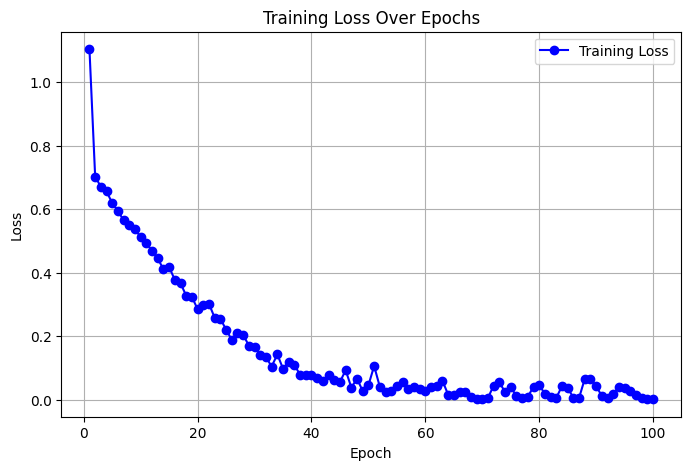


Validation Accuracy: 88.30%


In [ ]:
import time

start_time = time.perf_counter()
loss_values = []

print(f"Model: {model.name()}\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_values.append(running_loss/len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.6f}")

end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Execution time: {(execution_time)/60:.2f} minutes")
print(f"Avg time per epoch: {((execution_time/epochs)/60):.2f} minutes")

# Plot the loss graph
print()
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(validation_loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nValidation Accuracy: {100 * correct / total:.2f}%')